In [1]:
import os
import keras
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

import plotly.express as px
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

In [2]:
root_path = '../input/vegetable-image-dataset/Vegetable Images/train/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

class_dis = [len(os.listdir(root_path + name)) for name in class_names]

print(f"Total Number of Classes : {n_classes} \nClass_names : {class_names}")

Total Number of Classes : 15 
Class_names : ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [3]:
fig = px.pie(names=class_names, values=class_dis, title='class_distribution', hole=0.4)
fig.update_layout({'title': {'x':0.5}})
fig.show()

In [4]:
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

train_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
valid_ds = valid_gen.flow_from_directory(root_path.replace('train','validation'), class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
test_ds = test_gen.flow_from_directory(root_path.replace('train', 'test'), class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [5]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

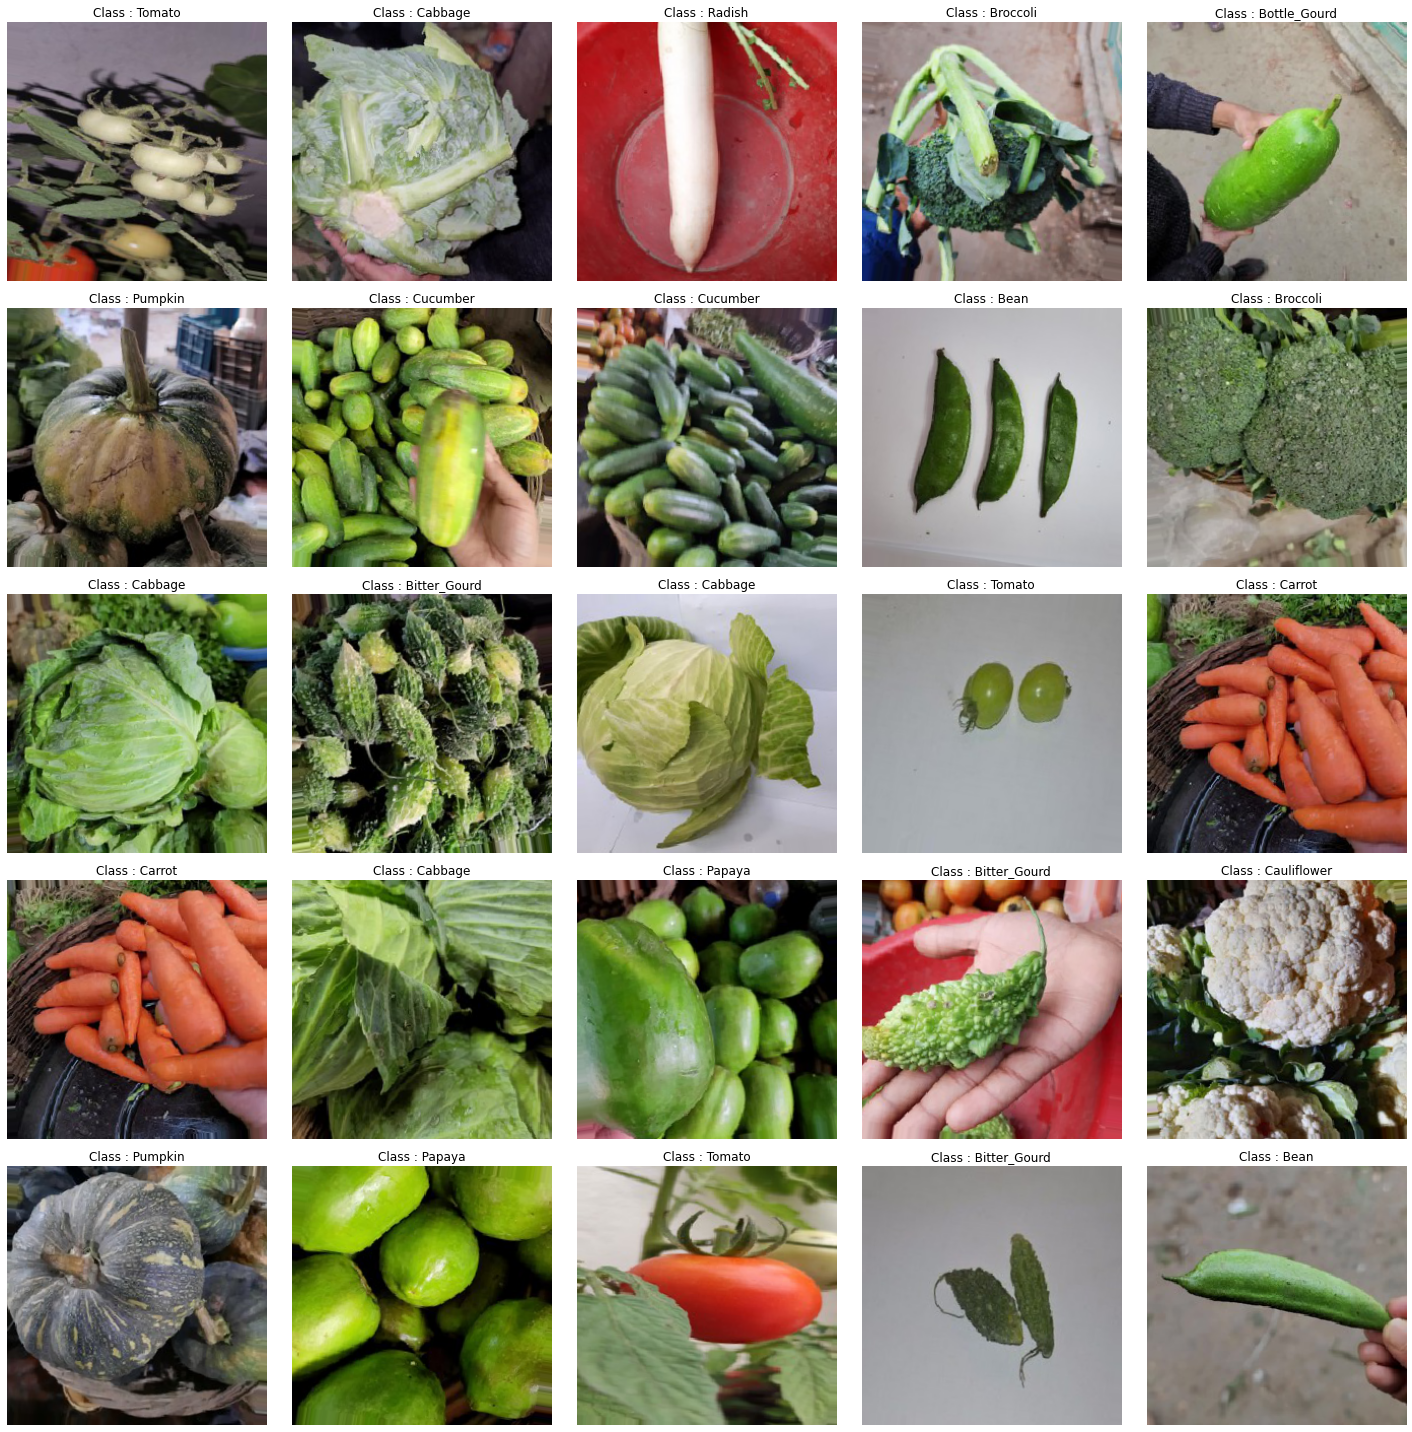

In [6]:
show_images()


In [7]:
base_model = ResNet50V2(input_shape=(256,256,3), include_top=False)
base_model.trainable = False

# Model Architecture
name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax')
], name=name)

# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

# Model Compiling
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
# model.fit(train_ds, validation_data=valid_ds, callbacks=cbs, epochs=50)

2022-10-28 05:33:03.683118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 05:33:03.687003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 05:33:03.687758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 05:33:03.689448: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step


In [8]:
model_path = '../input/vegetable/ResNet50V2- Vegetable-Classifier.h5'
model = load_model(model_path)

# Architecture
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                3855      
Total params: 24,093,199
Trainable params: 528,399
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
model.evaluate(test_ds)

2022-10-28 05:33:11.698526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-28 05:33:13.681238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 33s 269ms/step - loss: 0.0290 - accuracy: 0.9910


[0.02896343171596527, 0.9909999966621399]

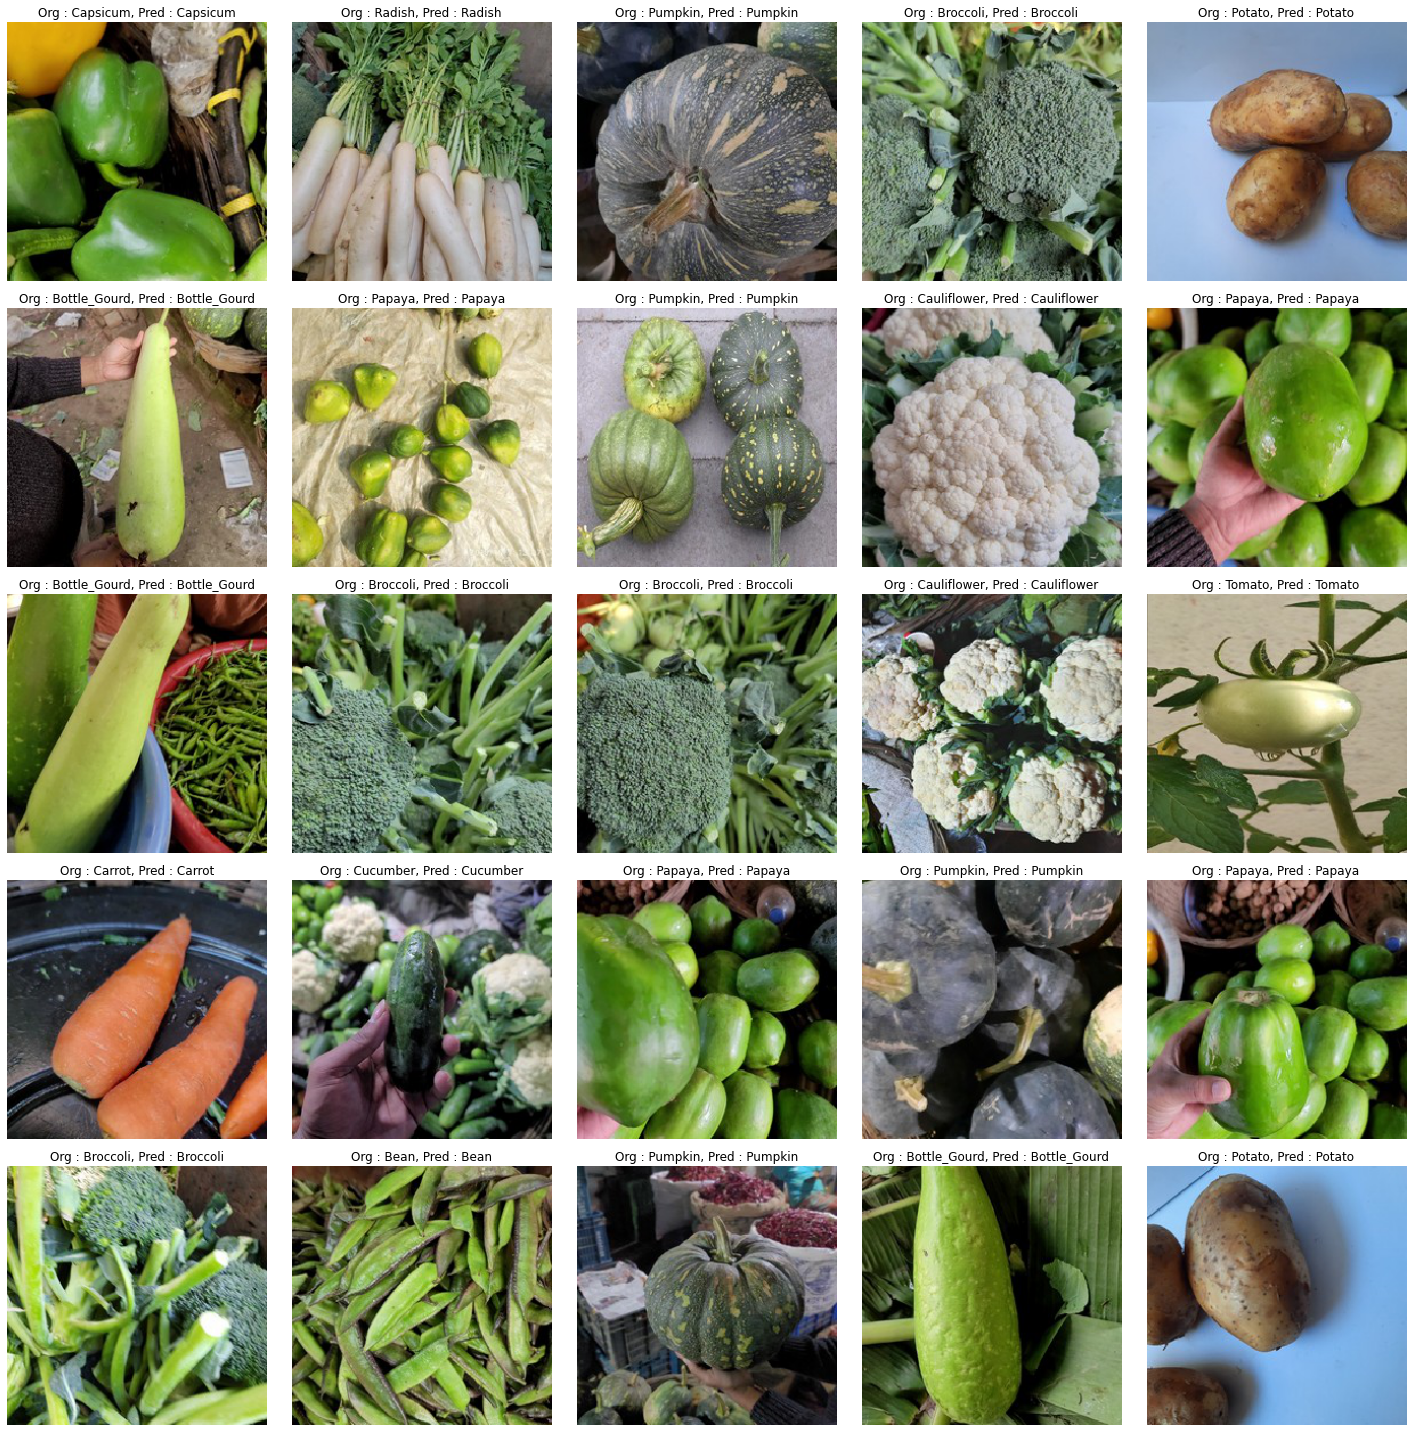

In [10]:
show_images(model=model, data=test_ds)